In [2]:
%matplotlib inline
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pylab import cm

from shapely.geometry import Point

from esda.getisord import G_Local
from esda.moran import Moran
from libpysal.weights import KNN

from tqdm.auto import tqdm
import random
import mapclassify
from collections import Counter
import statsmodels.formula.api as smf

<h3> Different skills used for 8 questions explored </h3>
<p>Combined 2 or more data frames: 5/8</p>
<p>Used 4 different datasets</p>
<ol>
  <li>Use of groupby and aggregate functions: 3/8</li>
  <li>Spatial analysis requiring sjoin: 3/8</li>
  <li>Spatial analysis requiring local or global autocorrelation: 5/8</li>
  <li>Linear regression analysis involving more than 5 independent variables: 3/8</li>
</ol>




In [3]:
# Setup
# 4 different datasets used

detroit_incidents=pd.read_csv('Detroit-RMS_Crime_Incidents.csv', dtype={'arrest_charge':'str', 'scout_car_area':'str','precinct':'str'})
scout_car_map = gpd.read_file('DPD_Scout_Car_Areas/DPD_SCAs.shp')
neighborhood_map= gpd.read_file('theNeighborhoods/theNeighborhoods.shp')
police_precincts_map = gpd.read_file('DPD_Police_Precincts/DPD_Police_Precincts.shp')
projection = "+proj=laea +lat_0=30 +lon_0=-95"
scout_car_map = scout_car_map.to_crs(projection)
neighborhood_map = neighborhood_map.to_crs(projection)
police_precincts_map = police_precincts_map.to_crs(projection)
detroit_incidents = gpd.GeoDataFrame(detroit_incidents, geometry=gpd.points_from_xy(detroit_incidents.longitude,detroit_incidents.latitude))
detroit_incidents.crs = "EPSG:4326"
detroit_incidents = detroit_incidents.to_crs(projection)

[None, None, None, None, None, None, None, None, None, None, None, None]

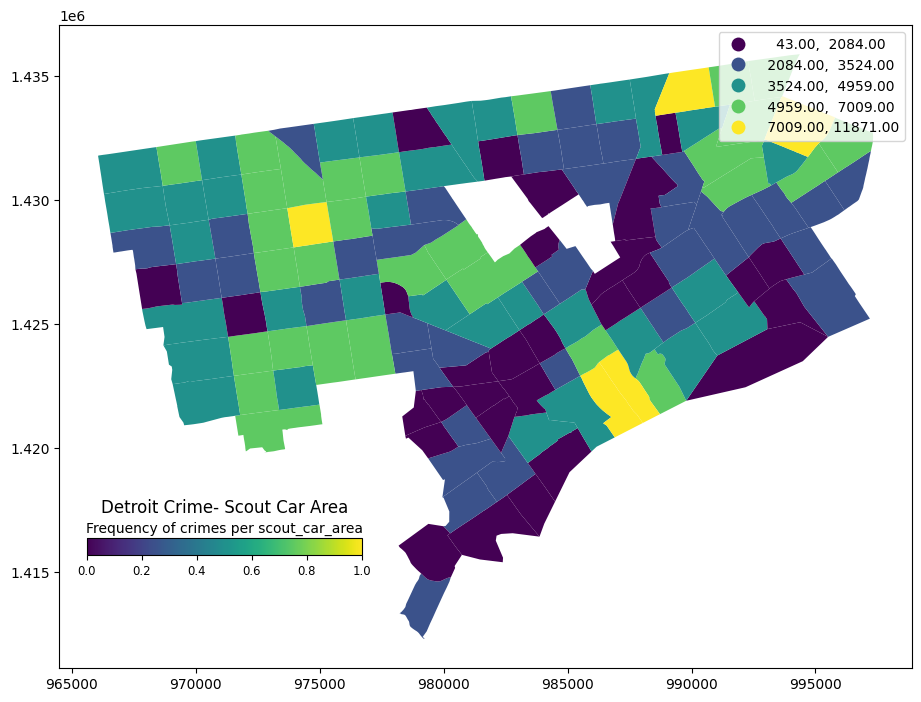

In [4]:
# Question 1: Does crime rate tend to follow regional patterns, with it being clustered more in specific scout car areas?
# Use of groupby and aggregate functions
# Spatial analysis requiring sjoin
# Spatial analysis requiring local or global autocorrelation
# Combines 2 or more dataframes
scout_incidents = gpd.sjoin(scout_car_map, detroit_incidents, how='inner', predicate='contains')
fidCount=scout_incidents.groupby('FID')['scout_car_area'].apply(lambda x: x.count()).to_frame()
fidCount.columns=['FID_Count']
fidCount=fidCount.merge(scout_car_map[['geometry','FID']], left_index=True,right_on='FID',how='right')
fidCount.set_index('FID', inplace=True)
fidCount = gpd.GeoDataFrame(fidCount, geometry=fidCount['geometry'])
fidCount['FID_Count']=fidCount['FID_Count'].fillna(0)
figZ, ax = plt.subplots(1, figsize=(11,8.5))
ax.axis('on')
fidCount.plot(ax=ax, column='FID_Count',scheme='fisher_jenks',legend=True)
cbax = figZ.add_axes([0.15, 0.25, 0.25, 0.02])
cb2 = mpl.colorbar.ColorbarBase(cbax, orientation='horizontal')
cb2.set_label(r'Frequency of crimes per scout_car_area')
cb2.ax.xaxis.set_label_position('top')
cb2.ax.xaxis.label.set_multialignment('center')
plt.title("Detroit Crime- Scout Car Area")
plt.setp(plt.getp(cb2.ax.axes, 'xticklabels'), fontsize='small')

In [5]:
listws25 = KNN.from_dataframe(fidCount, k=25)
mi = Moran(fidCount['FID_Count'], listws25)
print("Moran's I for relationship between crime rate and scout_car_area:", mi.I) 
print("Moran's p-value (under normality assumption) for relationship between crime rate and scout_car_area: %0.19f" % mi.p_norm) 

Moran's I for relationship between crime rate and scout_car_area: 0.1116457434538516
Moran's p-value (under normality assumption) for relationship between crime rate and scout_car_area: 0.0000000126629711161


[None, None, None, None, None, None, None, None, None, None, None, None]

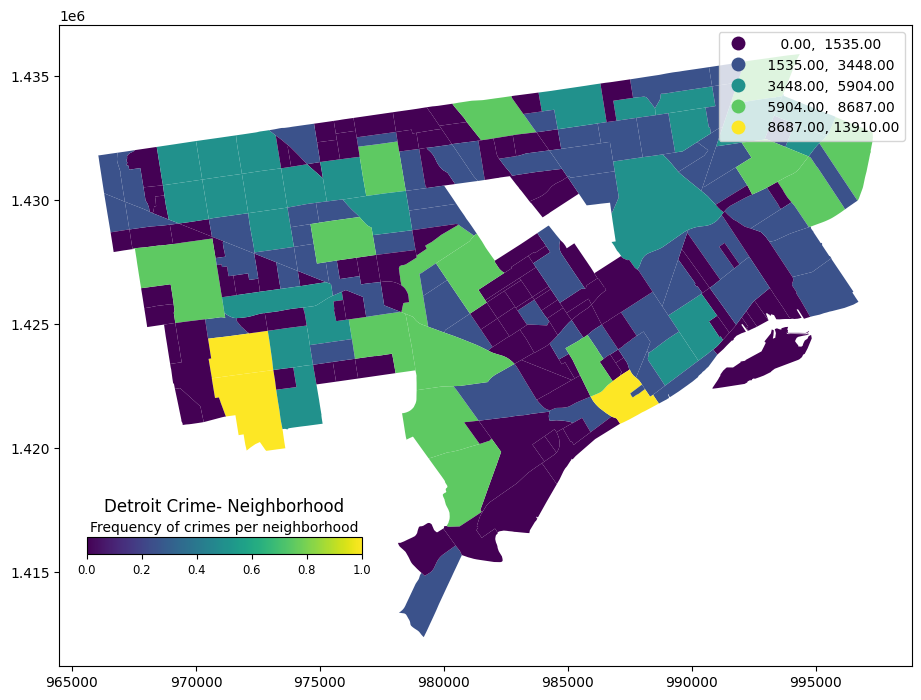

In [6]:
# Question 2: Does crime rate tend to follow regional patterns, with it being clustered more in specific neighborhoods?
# Use of groupby and aggregate functions
# Spatial analysis requiring sjoin
# Spatial analysis requiring local or global autocorrelation
# Combines 2 or more dataframes

neighborhood_incidents = gpd.sjoin(neighborhood_map, detroit_incidents, how='inner', predicate='contains')
neighCount=neighborhood_incidents.groupby('neighborhood')['neighborhood'].apply(lambda x: x.count()).to_frame()
neighCount.columns=['Neigh_Count']
neighCount=neighCount.merge(neighborhood_map[['geometry','name']], left_index=True,right_on='name',how='right')
neighCount.set_index('name', inplace=True)
neighCount = gpd.GeoDataFrame(neighCount, geometry=neighCount['geometry'])
neighCount['Neigh_Count']=neighCount['Neigh_Count'].fillna(0)
figZ, ax = plt.subplots(1, figsize=(11,8.5))
ax.axis('on')
neighCount.plot(ax=ax, column='Neigh_Count',scheme='fisher_jenks',legend=True)
cbax = figZ.add_axes([0.15, 0.25, 0.25, 0.02])
cb2 = mpl.colorbar.ColorbarBase(cbax, orientation='horizontal')
cb2.set_label(r'Frequency of crimes per neighborhood')
cb2.ax.xaxis.set_label_position('top')
cb2.ax.xaxis.label.set_multialignment('center')
plt.title("Detroit Crime- Neighborhood")
plt.setp(plt.getp(cb2.ax.axes, 'xticklabels'), fontsize='small')

In [7]:
neighCount.reset_index(inplace=True)
listws25 = KNN.from_dataframe(neighCount, k=25)
mi = Moran(neighCount['Neigh_Count'], listws25)
print("Moran's I for relationship between crime rate and neighborhoods:", mi.I) 
print("Moran's p-value (under normality assumption) for relationship between crime rate and neigborhood: %0.19f" % mi.p_norm) 

Moran's I for relationship between crime rate and neighborhoods: 0.04688727373214758
Moran's p-value (under normality assumption) for relationship between crime rate and neigborhood: 0.0030242372509110549


[None, None, None, None, None, None, None, None, None, None, None, None]

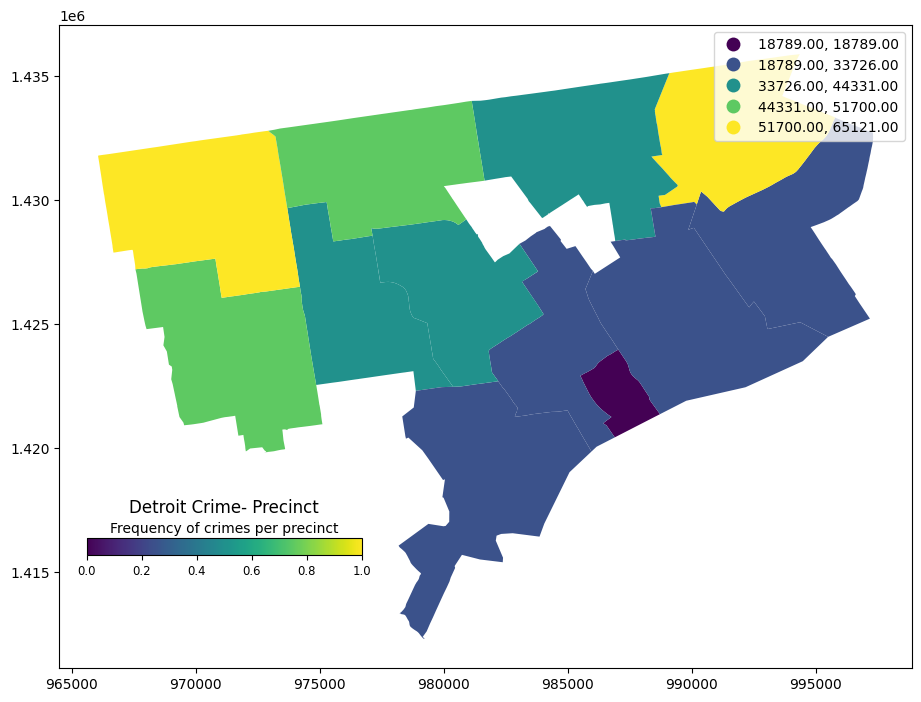

In [8]:
# Question 3: Does crime rate tend to follow regional patterns, with it being clustered more in specific precincts?
# Use of groupby and aggregate functions
# Spatial analysis requiring sjoin
# Spatial analysis requiring local or global autocorrelation
# Combines 2 or more dataframes
precinct_incidents = gpd.sjoin(police_precincts_map, detroit_incidents, how='inner', predicate='contains')
precCount=precinct_incidents.groupby('Precinct')['Precinct'].apply(lambda x: x.count()).to_frame()
precCount.columns=['Prec_Count']
precCount=precCount.merge(police_precincts_map[['geometry','Precinct']], left_index=True,right_on='Precinct',how='right')
precCount.set_index('Precinct', inplace=True)
precCount = gpd.GeoDataFrame(precCount, geometry=precCount['geometry'])
precCount['Prec_Count']=precCount['Prec_Count'].fillna(0)
figZ, ax = plt.subplots(1, figsize=(11,8.5))
ax.axis('on')
precCount.plot(ax=ax, column='Prec_Count',scheme='fisher_jenks',legend=True)
cbax = figZ.add_axes([0.15, 0.25, 0.25, 0.02])
cb2 = mpl.colorbar.ColorbarBase(cbax, orientation='horizontal')
cb2.set_label(r'Frequency of crimes per precinct')
cb2.ax.xaxis.set_label_position('top')
cb2.ax.xaxis.label.set_multialignment('center')
plt.title("Detroit Crime- Precinct")
plt.setp(plt.getp(cb2.ax.axes, 'xticklabels'), fontsize='small')

In [9]:
listws25 = KNN.from_dataframe(precCount, k=11)
mi = Moran(precCount['Prec_Count'], listws25)
print("Moran's I for relationship between crime rate and precincts:", mi.I) 
print("Moran's p-value (under normality assumption) for relationship between crime rate and precinct: %0.19f" % mi.p_norm) 

Moran's I for relationship between crime rate and precincts: -0.0909090909090909
Moran's p-value (under normality assumption) for relationship between crime rate and precinct: 0.9999999940552968258


In [10]:
# Question 4: Are parks in detroit spatially auto correlated?
# Spatial analysis requiring local or global autocorrelation
# Combines 2 or more dataframes
neighCountPH=neighCount.merge(neighborhood_map[['parks','homes','name']], left_on='name',right_on='name',how='right')
neighCountPH = gpd.GeoDataFrame(neighCountPH, geometry=neighCountPH['geometry'])
neighCountPH['parks']=neighCountPH['parks'].fillna(0)
neighCountPH['homes']=neighCountPH['homes'].fillna(0)
listws25 = KNN.from_dataframe(neighCountPH, k=25)
mi = Moran(neighCountPH['parks'], listws25)
print("Moran's I for parks:", mi.I) 
print("Moran's p-value (under normality assumption) for parks: %0.19f" % mi.p_norm) 


Moran's I for parks: 0.10097910213911113
Moran's p-value (under normality assumption) for parks: 0.0000000011992706828


In [11]:
# Question 5: Are homes in detroit spatially auto correlated?
# Spatial analysis requiring local or global autocorrelation
# Combines 2 or more dataframes
neighCountPH['homes']=neighCountPH['homes'].fillna(0)
mi = Moran(neighCountPH['homes'], listws25)
print("Moran's I for homes:", mi.I) 
print("Moran's p-value (under normality assumption) for homes: %0.19f" % mi.p_norm) 

Moran's I for homes: 0.14390305379234442
Moran's p-value (under normality assumption) for homes: 0.0000000000000000000


In [12]:
# Question 6: Is there a correlation between homes in relation to zip_code, scout_car_area, neighborhood, council_district, and precinct?
# Linear regression analysis involving more than 5 independent variables

model = smf.ols('homes ~ C(zip_code) + C(scout_car_area) + C(neighborhood) + C(council_district) + C(precinct)', data=neighborhood_incidents)
result=model.fit()
result.summary()

In [ ]:
# Question 7: Is there a correlation between hour of day in relation to zip_code, scout_car_area, neighborhood, council_district, and precinct?
# Linear regression analysis involving more than 5 independent variables

model = smf.ols('hour_of_day ~ C(zip_code) + C(scout_car_area) + C(neighborhood) + C(council_district) + C(precinct)', data=neighborhood_incidents)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hour_of_day   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.664
Date:                Thu, 30 Mar 2023   Prob (F-statistic):          6.00e-317
Time:                        15:47:57   Log-Likelihood:            -1.6930e+06
No. Observations:              492711   AIC:                         3.387e+06
Df Residuals:                  492325   BIC:                         3.391e+06
Df Model:                         385                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        13.6007      0.876     15.530      0.000      11.884      15.317
C(zip_code)[T.48202]                             -0.6902      0.303     -2.278      0.023      -1.284      -0.096
C(zip_code)[T.48203]                             -1.3993      0.423     -3.311      0.001      -2.228      -0.571
C(zip_code)[T.48204]                             -1.3639      0.339     -4.029      0.000      -2.027      -0.700
C(zip_code)[T.48205]                             -0.7712      0.379     -2.033      0.042      -1.515      -0.028
C(zip_code)[T.48206]                             -1.2897      0.324     -3.986      0.000      -1.924      -0.656
C(zip_code)[T.48207]                             -0.1538      0.281     -0.548      0.584      -0.704       0.396
C(zip_code)[T.48208]                             -0.5217      0.288     -1.814      0.070      -1.085       0.042
C(zip_code)[T.48209]                             -0.2486      0.393     -0.633      0.527      -1.018       0.521
C(zip_code)[T.48210]                             -1.1210      0.376     -2.981      0.003      -1.858      -0.384
C(zip_code)[T.48211]                             -0.7175      0.335     -2.143      0.032      -1.374      -0.061
C(zip_code)[T.48212]                             -0.9258      0.440     -2.105      0.035      -1.788      -0.064
C(zip_code)[T.48213]                             -0.6819      0.353     -1.933      0.053      -1.373       0.010
C(zip_code)[T.48214]                             -0.8239      0.339     -2.428      0.015      -1.489      -0.159
C(zip_code)[T.48215]                             -0.4484      0.449     -0.998      0.318      -1.329       0.432
C(zip_code)[T.48216]                             -0.7742      0.311     -2.489      0.013      -1.384      -0.165
C(zip_code)[T.48217]                              1.7216      2.930      0.588      0.557      -4.021       7.464
C(zip_code)[T.48219]                             -1.1057      0.522     -2.120      0.034      -2.128      -0.083
C(zip_code)[T.48221]                             -1.5795      0.369     -4.283      0.000      -2.302      -0.857
C(zip_code)[T.48223]                             -1.1699      0.454     -2.577      0.010      -2.060      -0.280
C(zip_code)[T.48224]                             -0.7527      0.421     -1.786      0.074      -1.579       0.073
C(zip_code)[T.48226]                             -0.7404      0.321     -2.303      0.021      -1.370      -0.110
C(zip_code)[T.48227]                             -1.4887      0.355     -4.191      0.000      -2.185      -0.792
C(zip_code)[T.48228]                             -1.3550      0.376     -3.604      0.000      -2.092      -0.618
C(zip

In [ ]:
# Question 8: Is there a correlation between day of week in relation to zip_code, scout_car_area, neighborhood, council_district, and precinct?
# Linear regression analysis involving more than 5 independent variables

model = smf.ols('day_of_week ~ C(zip_code) + C(scout_car_area) + C(neighborhood) + C(council_district) + C(precinct)', data=neighborhood_incidents)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            day_of_week   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.360
Date:                Thu, 30 Mar 2023   Prob (F-statistic):          1.94e-226
Time:                        15:48:34   Log-Likelihood:            -1.0390e+06
No. Observations:              492711   AIC:                         2.079e+06
Df Residuals:                  492325   BIC:                         2.083e+06
Df Model:                         385                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         4.4328      0.232     19.087      0.000       3.978       4.888
C(zip_code)[T.48202]                             -0.1822      0.080     -2.268      0.023      -0.340      -0.025
C(zip_code)[T.48203]                             -0.2067      0.112     -1.844      0.065      -0.426       0.013
C(zip_code)[T.48204]                             -0.1450      0.090     -1.615      0.106      -0.321       0.031
C(zip_code)[T.48205]                             -0.1804      0.101     -1.794      0.073      -0.378       0.017
C(zip_code)[T.48206]                             -0.0853      0.086     -0.995      0.320      -0.253       0.083
C(zip_code)[T.48207]                             -0.1383      0.074     -1.858      0.063      -0.284       0.008
C(zip_code)[T.48208]                             -0.1416      0.076     -1.857      0.063      -0.291       0.008
C(zip_code)[T.48209]                             -0.2106      0.104     -2.023      0.043      -0.415      -0.007
C(zip_code)[T.48210]                             -0.0789      0.100     -0.791      0.429      -0.274       0.117
C(zip_code)[T.48211]                             -0.2336      0.089     -2.631      0.009      -0.408      -0.060
C(zip_code)[T.48212]                             -0.0219      0.117     -0.188      0.851      -0.250       0.207
C(zip_code)[T.48213]                             -0.1449      0.094     -1.549      0.121      -0.328       0.038
C(zip_code)[T.48214]                             -0.1274      0.090     -1.415      0.157      -0.304       0.049
C(zip_code)[T.48215]                             -0.1991      0.119     -1.671      0.095      -0.433       0.034
C(zip_code)[T.48216]                             -0.1623      0.082     -1.967      0.049      -0.324      -0.001
C(zip_code)[T.48217]                             -0.9373      0.777     -1.206      0.228      -2.460       0.586
C(zip_code)[T.48219]                              0.0525      0.138      0.380      0.704      -0.219       0.324
C(zip_code)[T.48221]                             -0.1379      0.098     -1.410      0.159      -0.330       0.054
C(zip_code)[T.48223]                             -0.0978      0.120     -0.812      0.417      -0.334       0.138
C(zip_code)[T.48224]                             -0.1747      0.112     -1.564      0.118      -0.394       0.044
C(zip_code)[T.48226]                             -0.2088      0.085     -2.450      0.014      -0.376      -0.042
C(zip_code)[T.48227]                             -0.1447      0.094     -1.536      0.125      -0.329       0.040
C(zip_code)[T.48228]                             -0.3049      0.100     -3.058      0.002      -0.500      -0.109
C(zip